# **Quality Metrics Result Visualization**

In this notebook, the raw energy consumption data, with different configurations of inference batch sizes, is analyzed. The results are averaged over the five runs, along with the computation of the standard deviation for each tracked parameter.

In [248]:
# import required libraries
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glasbey
import os

In [ ]:
# get working directory, necessary to gather the data to be analyzed
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(f"Parent Directory: {parent_dir}")

## **Helper Functions**
Useful functions to properly format labels and visualize plots correctly.

In [250]:
def save_individual_plot(data, x_col, y_col, hue_col, xlabel, ylabel, filename, paletta, base):
    """
    Generates and saves a scatter plot with an overlaid Pareto front for
    quality metrics vs. GPU energy consumption.

    This function creates a scatter plot using Seaborn to visualize the relationship
    between a specified quality metric (y_col) and GPU energy consumption (x_col),
    with the different models distinguished by color and style (hue_col).
    The Pareto efficient set is also computed, highlighting the points on the front.

    Parameters:
    -----------
    data : pd.DataFrame
        The DataFrame containing the data to plot. Expected to include the
        columns specified by `x_col`, `y_col`, and `hue_col`.

    x_col : str
        The name of the column in `data` to be used for the x-axis (GPU energy).

    y_col : str
        The name of the column in `data` to be used for the y-axis (quality metric).

    hue_col : str
        The name of the column in `data` to be used for differentiating
        plot points by color (model name).

    xlabel : str
        The label for the x-axis.

    ylabel : str
        The label for the y-axis (name of the metric).

    filename : str
        The path and name for saving the generated plot file.

    paletta : list
        Color palette to be used for the scatterplot.

    baseline : str
        The baseline name used for the plot title.

    Returns:
    --------
    None
        The function does not return any value but saves the generated plot
        to the specified file path.
    """
    figure, axes = plt.subplots(figsize=(10, 5))
    sns.set_theme(style="whitegrid")
    font_path = current_dir + r"\Times-Roman Regular.ttf"
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.rcParams['legend.title_fontsize'] = 26
    plt.grid(axis='y', linestyle='--', linewidth=1.5, zorder=0)

    sns.scatterplot(
        data=data,
        x=x_col,
        y=y_col,
        hue=hue_col,
        style=hue_col,
        ax=axes,
        palette=paletta
    )

    if ylabel=="FAD":
        globales = combined_data[[f"gpu_energy", f"{metrics[metrica][0]}"]].to_numpy()
        # sort by x (energy consumption) ascending, then by y ({metrics[metr][0]}) ascending
        sorted_globales = globales[np.lexsort((globales[:, 1], globales[:, 0]))]
        globales_paretos = [sorted_globales[0]]
        for punti in sorted_globales[1:]:
            if punti[1] <= globales_paretos[-1][1]:  # lower y is better
                globales_paretos.append(punti)
    else:
        globales = combined_data[[f"gpu_energy", f"{metrics[metrica][0]}"]].to_numpy()
        # sort by x (energy consumption) ascending, then by y descending (higher is better for CLAPscore)
        sorted_globales = globales[np.lexsort((-globales[:, 1], globales[:, 0]))]
        globales_paretos = [sorted_globales[0]]
        for punti in sorted_globales[1:]:
            if punti[1] >= globales_paretos[-1][1]:  # higher y is better for CLAPscore
                globales_paretos.append(punti)

    globales_paretos = np.array(globales_paretos)

    axes.plot(
        globales_paretos[:, 0], globales_paretos[:, 1],
        linestyle='--', color='red', alpha=0.5, linewidth=1.5, label='Pareto Front'
    )
    markers = dict(zip(steps, seaborn_markers))

    # plot and highlight Pareto front markers
    for q, linea in enumerate(axes.lines):
        name = linea.get_label()
        data = combined_data[combined_data['model'] == name]

        unique_steps = data['steps'].unique().astype(int)

        x_val = data[f"gpu_energy"].values
        y_val = data[f'{metrics[metrica][0]}'].values

        marker_idx = 0
        for m in range(len(x_val)):
            mark = markers.get(unique_steps[marker_idx], None)
            if mark:
                axes.scatter(x_val[m], y_val[m], marker=mark, s=400, color=dictcolors[name])

                if [x_val[m], y_val[m]] in globales_paretos.tolist():
                    axes.scatter(x_val[m], y_val[m], color=dictcolors[name], marker=mark, s=600,
                                 edgecolors='red', linewidth=2, zorder=5)
            marker_idx = (marker_idx + 1) % len(unique_steps)

    axes.set_xlabel(xlabel, fontsize=26)
    axes.set_ylabel(ylabel, fontsize=26)
    ymin, ymax = axes.get_ylim()
    axes.set_ylim(ymin-0.01, ymax+0.01)
    axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    axes.tick_params(axis='x', labelsize=20)
    axes.tick_params(axis='y', labelsize=20)
    axes.set(xscale="log")
    axes.set_title(label=f"{base.upper()} - {ylabel}", fontsize=26)
    axes.set_xticks(custom_positions)
    axes.set_xticklabels(custom_labels, fontsize=20, fontname='Times New Roman')
    axes.legend([], [], frameon=False)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(figure)

In [251]:
def getdata(metr, modelli, base):
    """
    Retrieves and merges quality metrics and emission data for multiple models
    and filters by a specific baseline.

    Parameters:
    -----------
    metr : str
        The name of the quality metric to retrieve data for ("FAD" or "CLAP").

    modelli : list[str]
        A list of model names for which to retrieve and merge data.

    base : str
        The baseline name to filter the combined data by.

    Returns:
    --------
    pd.DataFrame
        A pandas DataFrame containing the merged quality metrics and emission
        data for all specified models, filtered to include only the rows
        corresponding to the specified baseline.
    """
    data = [[] for _ in modelli]

    for r, modello in enumerate(modelli):

        file_path = rf"{current_dir}\results\quality_metrics\{metr}\{modello}_{metrics[metr][0]}s.csv"
        data[r] = pd.read_csv(file_path)
        en_path = rf"{current_dir}\results\quality_metrics\emissions\{modello}\{modello}_emissions.csv"
        energy = pd.read_csv(en_path)
        for col in ['emissions', 'gpu_energy']:
            data[r] = data[r].merge(energy[['steps', 'baseline', col]], on=['steps', 'baseline'], how='left')

    combinat = []
    for r, modello in enumerate(modelli):
        temp_data = data[r].copy()
        combinat.append(temp_data)
    combinat = pd.concat(combinat, ignore_index=True)
    filtered_combinat = combinat[combinat["baseline"] == base]
    return filtered_combinat

In [252]:
def make_legend():
    """
    Generates, plots, and saves a combined legend for model names and
    inference steps used in the plots.

    Returns:
    --------
    None
        The function does not return any value but saves the generated legend
        figure to a PDF file.
    """
    model_handles = [
        plt.Line2D([0], [0], marker=seaborn_markers[0], color='w',
                   markerfacecolor=dictcolors[model], markersize=12)
        for model in models
    ]
    marker_labels = ["  10 Inf. Steps", "  25 Inf. Steps", "  50 Inf. Steps",
                     "100 Inf. Steps", "150 Inf. Steps", "200 Inf. Steps"]
    marker_handles = [
        plt.Line2D([0], [0], marker=seaborn_markers[i], color='w',
                   markerfacecolor='black', markersize=10)
        for i in range(len(seaborn_markers))
    ]
    fig2, axes2 = plt.subplots(figsize=(14, 1))
    axes2.axis("off")
    fig2.legend(model_handles, models, bbox_to_anchor=(0.925, 0.84), ncol=7, fontsize=20, markerscale=2, columnspacing=4.36)
    fig2.legend(marker_handles, marker_labels, bbox_to_anchor=(0.925, 0.28), ncol=6 , fontsize=20, markerscale=2, columnspacing=3.56)
    fig2.savefig(rf"{current_dir}\figures\quality_metrics\legends.pdf", bbox_inches='tight')
    plt.show()

## **Figure plotting**
Using the previously defined functions, we now can now plot the analyze the data.

In [ ]:
metrics = {"FAD": ["fad_score", "FAD"],
           "CLAP": ["clap_score", "CLAP Score"]}
seaborn_markers = ["o", "s", "D", "^", "<", "X"]
steps = [10, 25, 50, 100, 150, 200]
custom_positions = [10 ** -1, 20 ** -1, 30 ** -1, 40 ** -1, 50 ** -1, 10 ** 0]
custom_labels = [r"10$^{-1}$", "", "", "", r"50$^{-1}$", r"10$^{0}$"]
models = ["AudioLDM", "AudioLDM2", "SAO", "MAA", "MAA2", "Tango", "Tango2"]
color_models = ["a", "AudioLDM", "b", "AudioLDM2", "x", "c", "SAO",
          "MAA", "MAA2", "Tango", "Tango2", "y"]
colors = glasbey.create_palette(palette_size=len(color_models), colorblind_safe=True, cvd_severity=75)
dictcolors = dict(zip(color_models, colors))
newpalette = [dictcolors[key] for key in models if key in dictcolors]

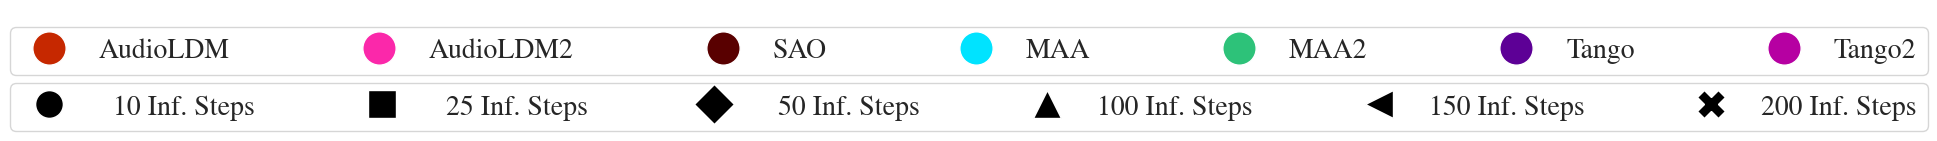

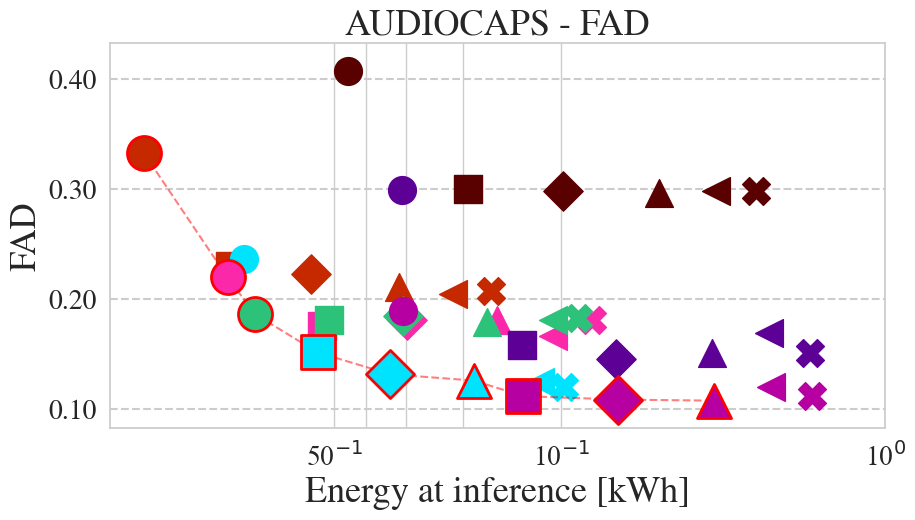

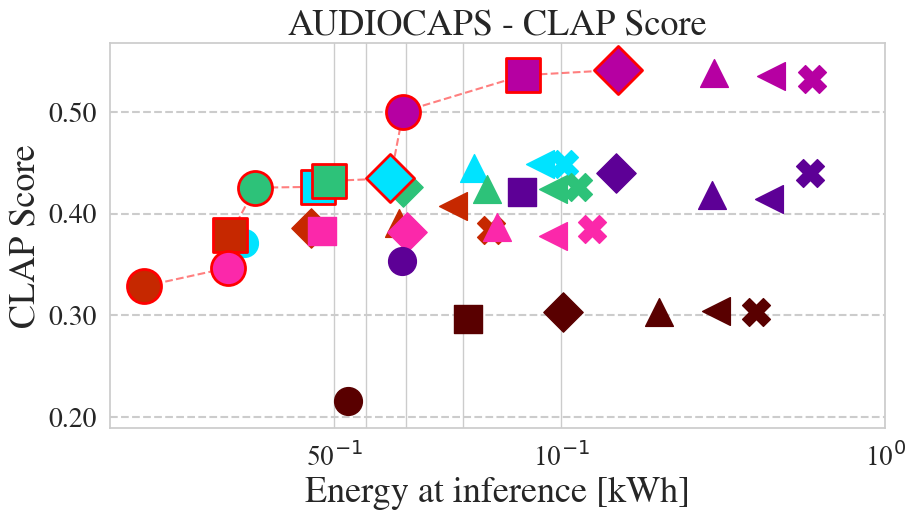

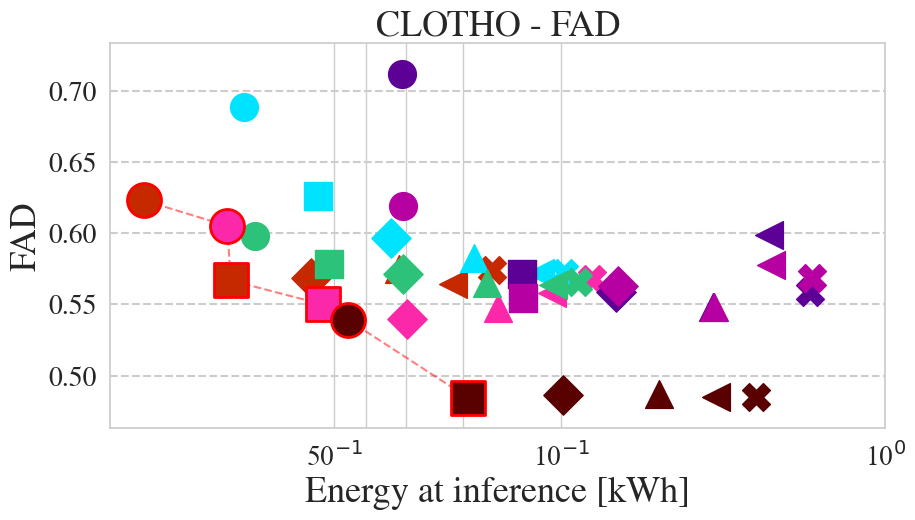

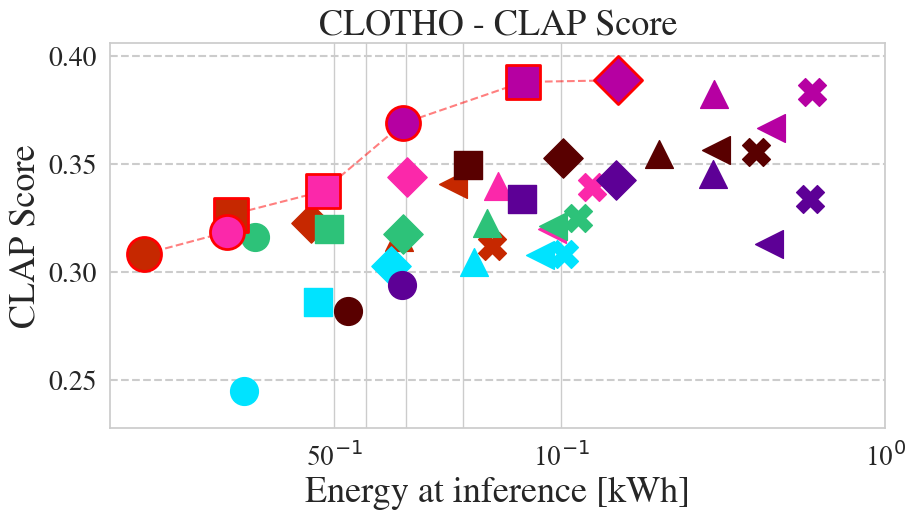

In [254]:
make_legend()

for baseline in ["audiocaps", "clotho"]:
    for metrica in ["FAD", "CLAP"]:
        combined_data = getdata(metrica, models, baseline)
        save_individual_plot(combined_data, "gpu_energy", f"{metrics[metrica][0]}", "model",
                              "Energy at inference [kWh]", f"{metrics[metrica][1]}",
                              rf"{current_dir}\figures\quality_metrics\{baseline}_{metrics[metrica][0]}.pdf",
                              newpalette, baseline)